# Kalman Filter (Forced Linear Advection Diffusion)

Kalman Filter のパッケージとしては pykalman(https://pykalman.github.io) があるが，<br>
Nan や観測データよりも細かいステップでの予測分布の更新など柔軟に対応できるプログラムを自分で作りたいというモチベーション

Kalman Filter について知りたい人は，以下の文献を参考にしてほしい．
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．
- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．

## -----------コードを書く前の下準備----------

### Linear Gauss State Space Model（線形・ガウス状態空間モデル）

一般に，カルマンフィルタでは，線形・ガウス状態空間モデルを考える．これは，次の様に表せる．
$$
\begin{align}
&x_{t+1} = F_tx_t + b + N(0,Q_t)\\
&y_t = H_tx_t + d + N(0,R_t)
\end{align}
$$
ここで，$x_t$は時刻$t$における状態変数，$y_t$は時刻$t$における観測変数，$F_t$はシステム行列，$Q_t$はシステムノイズの共分散行列，$H_t$は観測行列，$R_t$は観測ノイズの共分散行列，$b,d$は各モデルのオフセット（切片）を表す．

### Kalman Filter Algorithm

カルマンフィルターのアルゴリズムは，以下であった．
1. 初期状態のフィルタ分布の平均 $x_{0|0}$，共分散行列$V_{0|0}$を与える
1. $t=1$から$T$まで次の予測ステップ・フィルタステップを繰り返す

予測ステップ
$$
\begin{gather}
x_{t|t-1}=F_tx_{t-1|t-1}\\
V_{t|t-1}=F_tV_{t-1|t-1}F_t^T+G_tQ_tG_t
\end{gather}
$$

フィルタステップ
$$
\begin{gather}
K_t = V_{t|t-1}H_t^T (H_tV_{t|t-1}H_t^T+R_t)^{-1}\\
x_{t|t} = x_{t|t-1}+K_t(y_t-H_tx_{t|t-1})\\
V_{t|t} = V_{t|t-1} - K_t H_t V_{t|t-1}
\end{gather}
$$

### RTS Smoothing Algorithm

カルマンフィルタによって，$x_{T|T},V_{T|T}$が得られたら，$t=T-1,\cdots,0$に対して，
$$
\begin{gather*}
A_t=V_{t|t}F_{t+1}^TV_{t+1|t}^{-1}\\
x_{t|T} = x_{t|t} + A_t(x_{t+1|T} - x_{t+1|t})\\
V_{t|T} = V_{t|t} + A_t(V_{t+1|T} - V_{t+1|t})A_t^T
\end{gather*}
$$
によって固定区間平滑化分布の平均$x_{t|T}$と共分散行列$V_{t|T}$がわかる．ここで，$A_t$は固定区間平滑化ゲインと呼ばれている．

## ----------コード作成----------

ディレクトリ構造について
- Data_Assimilation > phase2 > source : saving place for source
- Data_Assimilation > phase2 > plot : saving place for plot result

バージョンについて
- Mac OS 10.13
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1
- scipy 0.19.0

In [1]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy import interpolate

# kalman filter
from kalman_filter import *

### カルマンフィルター実装テスト

In [2]:
# Euler forward differential
def Euler_forward_differential (state, m, w, k, r, dt, t) :
    '''
    <Input Variables>
    state [n_dim] {float} : position and velocity (x, v) (位置と速度)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    t {int} : time (ステップ番号)
    
    <Variables>
    x {float} : position (位置)
    v {float} : velocity (速度)
    '''
    x = state[0]
    v = state[1]

    state[0] = x + dt * v
    state[1] = v + dt / m * (- k * x - r * v + w(t * dt))
    return state

# perfect simulation
def perfect_simulation (initial_state, m, w, k, r, dt, T) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_perf {float} : perfect forcing (外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_perf = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_perf[0] = w(0)
    for t in range(L) :
        state = Euler_forward_differential(state, m, w, k, r, dt, t)
        x[t + 1] = state[0]
        v[t + 1] = state[1]
        w_perf[t + 1] = w((t + 1) * dt)
    return x, v, w_perf

# observation (perfect simulation + noise)
def make_observation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        else :
            noise = 0
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

# simulation (perfect simulation + noise)
def make_simulation (initial_state, m, w, k, r, dt, T, noise_sd) :
    '''
    <Input Variables>
    initial_state [n_dim] {float} : initial state (x0, v0) (初期状態変数)
    m {float} : mass (質量)
    w {function} : forcing function w(t) (強制力関数)
    k {float} : ocillation coefficient (振動係数)
    r {float} : decay coefficient (減衰係数)
    dt {float} : time resolution (時間区分)
    T {float} : end time (最終時間)
    noise_sd {float} : standard deviation of Nomal noise (観測ノイズの標準偏差)
    
    <Variables in this function>
    L {int} : length of time (ステップ数)
    x {float} : position (位置)
    v {float} : velocity (速度)
    w_obs {float} : forcing (観測外力)
    state [n_dim] {float} : position and velocity (updated) (状態)
    noise [n_dim] {float} : normal noise ~ N(0, noise_sd**2) (観測ノイズ)
    '''
    L = math.ceil(T / dt) + 1
    x = np.zeros(L + 1)
    v = np.zeros(L + 1)
    w_obs = np.zeros(L + 1)
    state = initial_state
    x[0] = state[0]
    v[0] = state[1]
    w_obs[0] = w(0)
    for t in range(L) :
        if t%2 == 0 :
            noise = rd.normal(0, noise_sd, size = 1)
        w_obs[t + 1] = w((t + 1) * dt) + noise
        state = Euler_forward_differential(state, m, w, k, r, dt, t) + np.array([dt / m * noise, 0])
        x[t + 1] = state[0]
        v[t + 1] = state[1]
    return x, v, w_obs

In [3]:
# forcing function
def w (t) :
    '''
    <Input Variable>
    t {float} : time
    '''
    return np.sin(np.pi * t / 5)

In [4]:
# decide parameters
#n_dim_sys = 2
#n_dim_obs = 1
perf_initial = np.array([5.0, 0.0])
sim_initial = np.array([[6.0, 0.0]])
obs_initial = perf_initial
m = 1.0
k = 0.5
r = 0.75
dt = 1
noise_sd = 1.0
sim_noise = 0.5**2
T = 100

In [5]:
wd = np.zeros(T + 2)
for t in range(T + 2) :
    wd[t] = w(t)

In [6]:
# setup matrix
F = np.array([[1, dt], [- k * dt / m, 1 - r * dt / m]])
G = np.array([[0], [dt / m]])
H = np.array([[1, 0]])
Gw = np.dot(np.array([G[:, 0]]).T, [wd]).T
V0 = np.array([[1, 0], [0, 0]])
Q = np.array([[sim_noise]])
R = np.array([[noise_sd**2]])

In [7]:
# confirmation
print('perf_initial:', perf_initial.shape)
print('sim_initial:', sim_initial.shape)
print('obs_initial:', obs_initial.shape)
print('F', F.shape)
print('G', G.shape)
print('H', H.shape)
print('Gw', Gw.shape)
print('V0', V0.shape)
print('Q', Q.shape)
print('R', R.shape)

perf_initial: (2,)
sim_initial: (1, 2)
obs_initial: (2,)
F (2, 2)
G (2, 1)
H (1, 2)
Gw (102, 2)
V0 (2, 2)
Q (1, 1)
R (1, 1)


In [8]:
x_perf, v_perf, w_perf = perfect_simulation(perf_initial, m, w, k, r, dt, T)
x_obs, v_obs, w_obs = make_observation(obs_initial, m, w, k, r, dt, T, noise_sd)

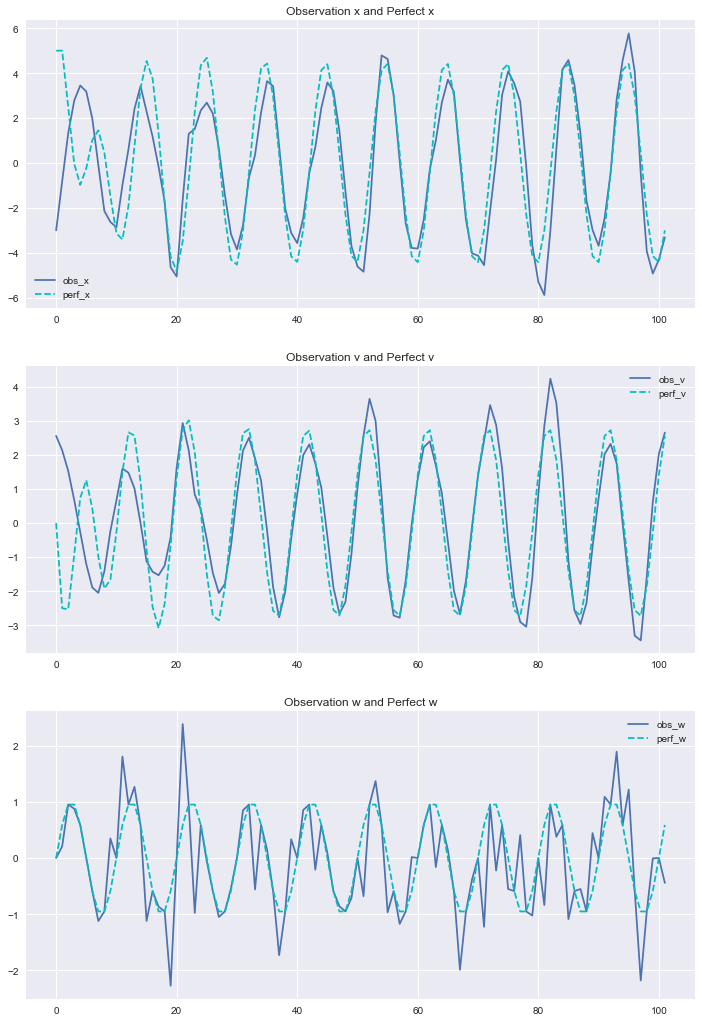

In [9]:
plt.figure(figsize = (12, 18))
plt.subplot(3, 1, 1)
plt.plot(x_obs, label = 'obs_x')
plt.plot(x_perf, linestyle = '--', color = 'c', label = 'perf_x')
plt.title("Observation x and Perfect x")
plt.legend(loc = 'best')

plt.subplot(3, 1, 2)
plt.plot(v_obs, label = 'obs_v')
plt.plot(v_perf, linestyle = '--', color = 'c', label = 'perf_v')
plt.title("Observation v and Perfect v")
plt.legend(loc = 'best')

plt.subplot(3, 1, 3)
plt.plot(w_obs, label = 'obs_w')
plt.plot(w_perf, linestyle = '--', color = 'c', label = 'perf_w')
plt.title("Observation w and Perfect w")
plt.legend(loc = 'best')
plt.show()

In [10]:
# make observation y
y  = np.array([x_obs]).T
print(y.shape)

(102, 1)


In [15]:
y[3] = np.nan
y[:5]

array([[-2.99425105],
       [-0.81753763],
       [ 1.31893615],
       [        nan],
       [ 3.45025168]])

In [16]:
kf = Kalman_Filter(y, sim_initial, V0, F, G, H, Q, R, Gw)
kf.filter()
kf.RTS_smooth()

 smooth calculating... t=102/102

nanでもうまくいった

### 結果の表示

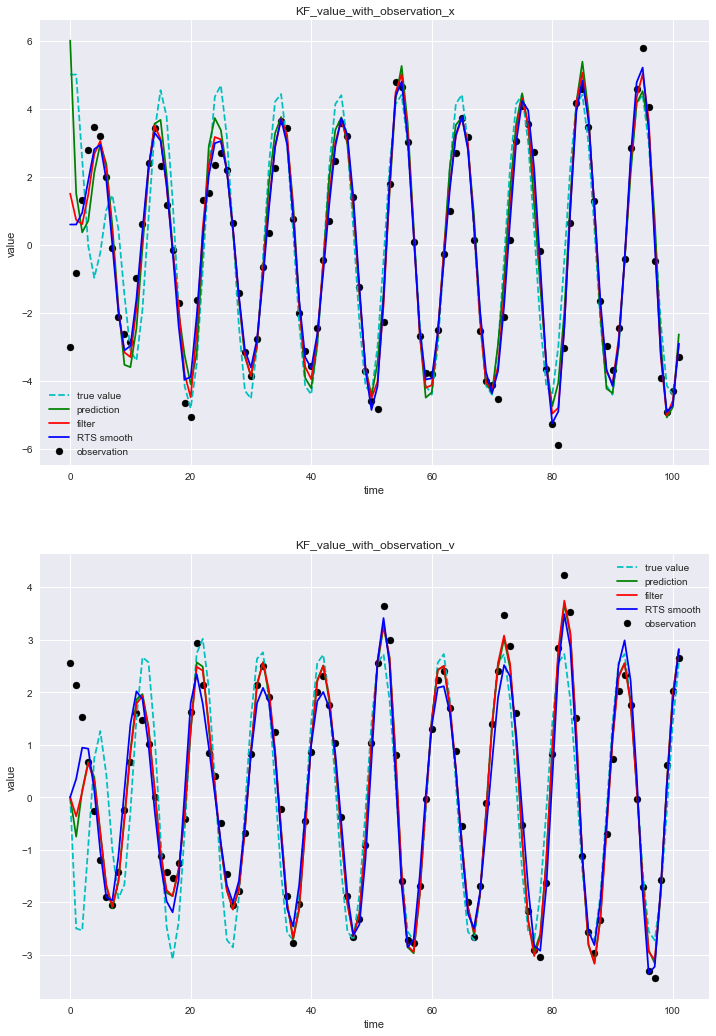

In [12]:
L = len(y)

plt.figure(figsize=(12, 18))

plt.subplot(2, 1, 1)
plt.scatter(range(L), x_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), x_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(kf.get_predicted_value(0), color = 'g', label =  'prediction')
plt.plot(kf.get_filtered_value(0), color = "r", label = "filter")
plt.plot(kf.get_RTS_smoothed_value(0), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_x")

plt.subplot(2, 1, 2)
plt.scatter(range(L), v_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), v_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(kf.get_predicted_value(1), color = 'g', label = 'prediction')
plt.plot(kf.get_filtered_value(1), color = "r", label = "filter")
plt.plot(kf.get_RTS_smoothed_value(1), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_v")

'''
plt.subplot(3, 1, 3)
plt.scatter(range(L), w_obs, color = "k", marker = 'o', label = "observation")
plt.plot(range(L), w_perf, color = 'c', linestyle = '--', label = 'true value')
plt.plot(w_perf + kf.get_RTS_smoothed_Forcing_Noise_Value(1), color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("KF_value_with_observation_force")
'''
#plt.savefig("../plot/171209_KF_position_velocity_force.png")
plt.show()

色々と試し施行

In [2]:
obs = [[1, np.nan, 2], [0,3,5]]
obs

[[1, nan, 2], [0, 3, 5]]

In [3]:
obs2 = np.ma.array(obs, mask = np.isnan(obs))
obs2

masked_array(data =
 [[1.0 -- 2.0]
 [0.0 3.0 5.0]],
             mask =
 [[False  True False]
 [False False False]],
       fill_value = 1e+20)

In [4]:
np.ma.getmask(obs2)

array([[False,  True, False],
       [False, False, False]], dtype=bool)